# Stock Q&A agent

* **Supervisor** pattern
* Supervisor will have access to 3 finance **Sub-agents**
* The sub-agents will be **wrapped as tools**
* Supervisor will have access to the **agents-as-tools**

### How is it different from the portfolio-research-agent that we built in earlier hands-on exercise?
The portfolio analaysis involved execution of all finance tools in parallel with an aggregator node that use the reports to generate a final research report and stock BUY/HOLD/SELL recommendation.

### Reference
[Build a personal assistant with subagents](https://docs.langchain.com/oss/python/langchain/multi-agent/subagents-personal-assistant)

### Note:
In this implementation we will use langgraph.create_react_agent as LangChain team recommends use of create_react_agent/create_agent instead of using the [langgraph-supervisor.create_supervisor function.](https://reference.langchain.com/python/langgraph/supervisor/)

In [1]:
from dotenv import load_dotenv

from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent

# Import the prebuilt agents

import finance.stock_research_agent as stock_research
import finance.industry_research_agent as industry_research
import finance.stock_trend_analyst as trend_analysis

# CHANGE THIS TO POINT TO YOUR OWN FILE
# Load the file that contains the API keys 
load_dotenv('C:\\Users\\raj\\.jupyter\\.env')

models = [
            {"model":"gpt-4.1-mini", "model_provider":"openai"},
            {"model":"command-r",  "model_provider":"cohere"},
            {"model": "moonshotai/kimi-k2-instruct", "model_provider": "groq"},
            {"model":"claude-3-5-sonnet-latest", "model_provider":"anthropic"},
            {"model": "llama-3.3-70b-versatile", "model_provider": "groq"}
]

USER_AGENT environment variable not set, consider setting it to identify your requests.


## 1. Finance sub-agents as tools

#### Stock research agent as tool

In [2]:
# Model used for the agents
chat_llm = init_chat_model(**models[0])

# Create & wrap stock research agent
stock_research_agent = stock_research.create_stock_research_agent(chat_llm)

@tool
def  stock_research_tool(ticker_symbol: str)->str:
    """
    Stock News Research tool.
    
    Specialized agent for analyzing financial news and generating structured reports
    on potential event-driven impacts to stock prices.
    
    Args:
        query (str): Stock-related query or news topic (e.g., earnings, FDA approvals).
    
    Returns:
        dict (JSON):
            report (str): Concise outlook based on latest news.
            reasons (list[str]): Key factors supporting the outlook.
            confidence_score (float): Confidence level from 0.0 (low) to 1.0 (high).
    
    Scope:
        - Focus: Event-driven stock price impact analysis.
        - Best for: Earnings, regulatory decisions, product launches, M&A impacts.
        - Limitations: Does not perform technical analysis or historical price modeling.
    
    Confidence interpretation:
        > 0.75 = strong evidence, 0.5–0.75 = moderate evidence, < 0.5 = tentative.
    """

    messages = {"messages":[HumanMessage(content= ticker_symbol)]}

    result = stock_research_agent.invoke(messages)
    
    return result["messages"][-1].text

# Unit testing
# result = stock_research_tool.invoke("AAPL")
# print(result)


#### Industry research agent as tool

In [3]:
# Create and wrap industry research agent
industry_research_agent = industry_research.create_industry_research_agent(chat_llm)

@tool
def  industry_research_tool(ticker_symbol: str)->str:
    """
    Industry News Research tool.
    
    Specialized agent for analyzing industry-sector trends and projecting their
    macro-level impact on specific company stocks.
    
    Args:
        ticker (str): Stock ticker symbol (e.g., "AAPL").
        query (str, optional): Focused research prompt (e.g., "Impact of AI regulation on semiconductors").
    
    Returns:
        dict (JSON):
            report (str): Concise stock outlook based on industry trends.
            reasons (list[str]): Key supporting factors (e.g., regulation, demand, market structure).
            industry (str): Identified industry sector.
            confidence_score (float): Confidence level from 0.0 (low) to 1.0 (high).
    
    Scope:
        - Focus: Macro-level industry trends affecting stock performance.
        - Best for: Sector trend analysis and thematic research.
        - Limitations: No company-level fundamental analysis; relies on recent industry news.
    
    Confidence interpretation:
        > 0.8 = strong consensus, 0.5–0.8 = mixed but directional, < 0.5 = limited/conflicting data.
    """
    messages = {"messages":[HumanMessage(content= ticker_symbol)]}

    result = industry_research_agent.invoke(messages)
    
    return result["messages"][-1].text

# Unit testing
# result = industry_research_tool.invoke("AAPL")
# print(result)

#### Stock trend analyst as tool

In [4]:
stock_trend_analyst_agent = trend_analysis.create_stock_trend_analyst_agent(chat_llm)

@tool
def  stock_trend_analyst_tool(ticker_symbol: str)->str:
    """
    Stock Trend Analyst tool.
    
    Specialized agent for analyzing historical stock price data and predicting
    near-term price direction.
    
    Args:
        ticker (str): Stock ticker symbol.
    
    Returns:
        dict (JSON):
            analysis (str): Concise outlook (higher, lower, or stable).
            reasons (list[str]): Key technical or historical factors supporting the view.
            confidence_score (float): Confidence level from 0.0 (low) to 1.0 (high).
    
    Scope:
        - Focus: Historical price-based trend analysis.
        - Time horizon: Near-future outlook.
        - Best for: Preliminary technical trend assessment.
        - Limitations: Excludes fundamental analysis and external market/news factors.
    
    Confidence interpretation:
        > 0.7 = high, 0.4–0.7 = medium, < 0.4 = low.
    """
    messages = {"messages":[HumanMessage(content= ticker_symbol)]}

    result = stock_trend_analyst_agent.invoke(messages)
    
    return result["messages"][-1].text

# Unit testing
# result = stock_trend_analyst_tool.invoke("AAPL")
# print(result)

# 2. Create the Supervisor


https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#2-create-supervisor-with-langgraph-supervisor

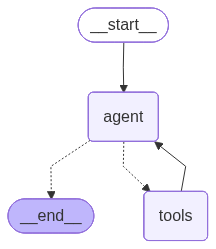

In [7]:
from typing import List, Literal
from enum import Enum
from pydantic import BaseModel, confloat


SUPERVISOR_PROMPT = (
    "You are a SUPERVISOR AGENT managing multiple specialized finance sub-agents as tools.\n"
    "Your goal is to answer the user's stock-related questions as accurately as possible.\n"
    "\n"
    "Rules:\n"
    "1. Only use the information returned by your sub-agents. Do not assume or hallucinate facts.\n"
    "2. Assign tasks to one sub-agent at a time. Do not call agents in parallel.\n"
    "3. After each sub-agent runs, check what information is still missing.\n"
    "4. Continue calling sub-agents until you have enough information to answer the user.\n"
    "5. Once sufficient information is collected, provide a clear, concise, and human-readable answer.\n"
    "\n"
    "Available sub-agents may provide:\n"
    "- Stock performance and price data\n"
    "- Company fundamentals and financial metrics\n"
    "- Industry trends\n"
    "- Recent news or events\n"
    "\n"
    "Remember: Your role is to orchestrate the sub-agents via tools and synthesize their results into a single answer.\n"
    "Only return the final answer once you have gathered enough information."
)




# Model used by the supervisor
supervisor_model = init_chat_model(**models[0])

# Create the supervisor react agent with the finance tools
supervisor_agent = create_react_agent(
    model = supervisor_model,
    tools = [stock_research_tool, industry_research_tool, stock_trend_analyst_tool],
    # name = "Stock QA agent",
    prompt = SUPERVISOR_PROMPT
)

supervisor_agent

# 3.Test the agent

In [8]:
# Sample questions
# Run the agent and check the tools invoked

user_message = "I have $10k worth of AAPL stock, is this a good time to sell"
# user_message = "What is the recent stock price for AAPL"
# user_message = "what is the latest news for AAPL"

messages = {"messages":[HumanMessage(content=user_message)],"remaining_steps": 10}
response  = supervisor_agent.invoke(messages)


# Print the tools that were invoked
for message in response["messages"]:
    # print(message)
    if isinstance(message, AIMessage):
        print(message.additional_kwargs, "\n")

{'tool_calls': [{'id': 'call_yaRaVY6pMV0rm2aFQDMMUJym', 'function': {'arguments': '{"ticker_symbol":"AAPL"}', 'name': 'stock_trend_analyst_tool'}, 'type': 'function'}], 'refusal': None} 

{'tool_calls': [{'id': 'call_8f3z5Ik4OpCoQm79hyyi1WiK', 'function': {'arguments': '{"ticker_symbol":"AAPL"}', 'name': 'stock_research_tool'}, 'type': 'function'}], 'refusal': None} 

{'refusal': None} 

